In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/seqfish' 
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)

In [3]:
### read xlsx file
instant_result = pd.read_excel(f'{data_path}output/seqfish/compared_methods/InSTAnT/unstacked_global_pvals_train_new.xlsx')### p value threshold<0.05
print("shape of the data: ", instant_result.shape)

shape of the data:  (500500, 8)


In [4]:
instant_result = instant_result[instant_result['gene_id1'] != instant_result['gene_id2']]
print("shape of the data after removing self-interactions: ", instant_result.shape)
print(instant_result.head())

shape of the data after removing self-interactions:  (499500, 8)
            g1g2 gene_id1 gene_id2    p_val_cond  Expected coloc  \
0    COL1A1, FN1   COL1A1      FN1  2.703799e-95       25.125242   
1   COL1A1, NID1   COL1A1     NID1  1.125453e-85       14.735552   
2  COL1A1, FBLN2   COL1A1    FBLN2  3.236646e-85       19.418223   
3     FBLN2, FN1    FBLN2      FN1  1.052986e-83       19.430419   
4  POLR2A, PRPF8   POLR2A    PRPF8  6.947819e-80        2.582896   

   Coloc. cells(Threshold<0.05)  Present cells  frac_cells  
0                           142            157    0.904459  
1                           117            157    0.745223  
2                           126            155    0.812903  
3                           125            155    0.806452  
4                            69            142    0.485915  


In [5]:
instant_result_1000_df  = instant_result[:1000]
instant_result_1000 = []
for i in range(1000):
    result_i = instant_result_1000_df.iloc[i]
    gene1 = result_i['gene_id1']
    gene2 = result_i['gene_id2']
    instant_result_1000.append((gene1, gene2))
instant_result_500 = instant_result_1000[:500]
instant_result_200 = instant_result_1000[:200]
instant_result_100 = instant_result_1000[:100]
instant_result_50 = instant_result_1000[:50]

In [6]:
# seqfish+ genes in extended data fig 3
protrusion20List = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Kif1c', 'Kctd10', 
                    'Dynll2', 'Arhgap11a', 'Dync1li2', 'Palld', 'Naa50']

nuclear20List = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',  
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1',
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3']
                 
cytoplasm20List = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

nuclearSub1List = ['Thbs1', 'Serpine1', 'Ptx3', 'Tnc']
nuclearSub2List = ['Flna', 'Flnb', 'Plec', 'Flnc', 'Iqgap1']
nuclearSub3List = ['Numa1', 'Gorasp2']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba 

def create_color_cmap(source_color,target_color0, target_color, name='custom_cmap'):

    colors = [
        to_rgba(source_color),        
        to_rgba(target_color0),
        to_rgba(target_color)  
    ]

    return LinearSegmentedColormap.from_list(name, colors)
custom_cmap = create_color_cmap('#FEFEE1','#9bc07c','#081D58', name='white_to_red')

In [8]:
embeddings_np = np.load(f'{data_path}output/seqfish/embeddings_train.npy')
print("shape of the data: ", embeddings_np.shape)

train_count_sum = np.load(f'{data_path}output/seqfish/train_count_sum.npy') 
print("shape of the data: ", train_count_sum.shape)

shape of the data:  (157, 1000, 384)
shape of the data:  (157, 1000)


In [ ]:
from tqdm import tqdm
from scipy.spatial.distance import cdist
# Compute pairwise distances between gene embeddings for each cell
num_cells, num_genes, embedding_dim = embeddings_np.shape
most_similar_genes_all_cells = {gene: [] for gene in gene_names}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
gene_similarity = np.zeros((len(gene_names), len(gene_names)))
k = 10
for cell in tqdm(range(num_cells)):
    distances = cdist(embeddings_np[cell], embeddings_np[cell], metric='cosine') # gene*gene
    
    # Identify the most similar 10 genes of each gene in a cell
    idx = 0 
    for gene in gene_names:
        if train_count_sum[cell][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:k+1]  # Exclude self-distance
            gene_similarity[idx,most_similar_genes] += 1
        idx += 1

gene_similarity = gene_similarity/ (train_count_sum!=0).sum(axis=0).reshape(-1, 1).repeat(len(gene_names), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)

upper_triangle = np.triu(gene_similarity_sym)
gene_pairs_1000_SVC = []
for i in range(1000):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    gene_pairs_1000_SVC.append((gene_names[idx1].upper(),gene_names[idx2].upper()))
    upper_triangle[idx1,idx2] = 0
gene_pairs_500_SVC = gene_pairs_1000_SVC[:500]
gene_pairs_200_SVC = gene_pairs_1000_SVC[:200]
gene_pairs_100_SVC = gene_pairs_1000_SVC[:100]
gene_pairs_50_SVC = gene_pairs_1000_SVC[:50]

100%|██████████| 157/157 [00:19<00:00,  8.00it/s]


In [10]:
common_pairs_50 = []
for i in range(50):
    gene1,gene2 = gene_pairs_50_SVC[i]
    if (gene1,gene2) in instant_result_50 or (gene2,gene1) in instant_result_50:
        common_pairs_50.append((gene1,gene2))
print("common_pairs_50:",len(common_pairs_50))
SVC_specific_pairs_50 = [i for i in gene_pairs_50_SVC if i not in common_pairs_50]
instant_specific_pairs_50 = []
for i in range(50):
    gene1,gene2 = instant_result_50[i]
    if (gene1,gene2) not in gene_pairs_50_SVC and (gene2,gene1) not in gene_pairs_50_SVC:
        instant_specific_pairs_50.append((gene1,gene2))

common_pairs_100 = []
for i in range(100):
    gene1,gene2 = gene_pairs_100_SVC[i]
    if (gene1,gene2) in instant_result_100 or (gene2,gene1) in instant_result_100:
        common_pairs_100.append((gene1,gene2))
print("common_pairs_100:",len(common_pairs_100))
SVC_specific_pairs_100 = [i for i in gene_pairs_100_SVC if i not in common_pairs_100]
instant_specific_pairs_100 = []
for i in range(100):
    gene1,gene2 = instant_result_100[i]
    if (gene1,gene2) not in gene_pairs_100_SVC and (gene2,gene1) not in gene_pairs_100_SVC:
        instant_specific_pairs_100.append((gene1,gene2))

common_pairs_200 = []
for i in range(200):
    gene1,gene2 = gene_pairs_200_SVC[i]
    if (gene1,gene2) in instant_result_200 or (gene2,gene1) in instant_result_200:
        common_pairs_200.append((gene1,gene2))
print("common_pairs_200:",len(common_pairs_200))
SVC_specific_pairs_200 = [i for i in gene_pairs_200_SVC if i not in common_pairs_200]
instant_specific_pairs_200 = []
for i in range(200):
    gene1,gene2 = instant_result_200[i]
    if (gene1,gene2) not in gene_pairs_200_SVC and (gene2,gene1) not in gene_pairs_200_SVC:
        instant_specific_pairs_200.append((gene1,gene2))

common_pairs_500 = []
for i in range(500):
    gene1,gene2 = gene_pairs_500_SVC[i]
    if (gene1,gene2) in instant_result_500 or (gene2,gene1) in instant_result_500:
        common_pairs_500.append((gene1,gene2))
print("common_pairs_500:",len(common_pairs_500))
SVC_specific_pairs_500 = [i for i in gene_pairs_500_SVC if i not in common_pairs_500]
instant_specific_pairs_500 = []
for i in range(500):
    gene1,gene2 = instant_result_500[i]
    if (gene1,gene2) not in gene_pairs_500_SVC and (gene2,gene1) not in gene_pairs_500_SVC:
        instant_specific_pairs_500.append((gene1,gene2))

common_pairs_1000 = []
for i in range(1000):
    gene1,gene2 = gene_pairs_1000_SVC[i]
    if (gene1,gene2) in instant_result_1000 or (gene2,gene1) in instant_result_1000:
        common_pairs_1000.append((gene1,gene2))
print("common_pairs_1000:",len(common_pairs_1000))
SVC_specific_pairs_1000 = [i for i in gene_pairs_1000_SVC if i not in common_pairs_1000]
instant_specific_pairs_1000 = []
for i in range(1000):
    gene1,gene2 = instant_result_1000[i]
    if (gene1,gene2) not in gene_pairs_1000_SVC and (gene2,gene1) not in gene_pairs_1000_SVC:
        instant_specific_pairs_1000.append((gene1,gene2))
common_pairs_num = [len(common_pairs_1000), len(common_pairs_500), len(common_pairs_200), len(common_pairs_100), len(common_pairs_50)]

common_pairs_50: 36
common_pairs_100: 78
common_pairs_200: 139
common_pairs_500: 310
common_pairs_1000: 540


In [11]:
varified_pairs_SVC_50 = []
for (gene1, gene2) in SVC_specific_pairs_50:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_SVC_50.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_SVC_50.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_SVC_50.append((gene1, gene2))
print("varified_pairs_SVC_50:", len(varified_pairs_SVC_50), varified_pairs_SVC_50)

varified_pairs_instant_50 = []
for (gene1, gene2) in instant_specific_pairs_50:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_instant_50.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_instant_50.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_instant_50.append((gene1, gene2))
print("varified_pairs_instant_50:", len(varified_pairs_instant_50), varified_pairs_instant_50)
print("===================================")
varified_pairs_SVC_100 = []
for (gene1, gene2) in SVC_specific_pairs_100:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_SVC_100.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_SVC_100.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_SVC_100.append((gene1, gene2))
print("varified_pairs_SVC_100:", len(varified_pairs_SVC_100), varified_pairs_SVC_100)

varified_pairs_instant_100 = []
for (gene1, gene2) in instant_specific_pairs_100:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_instant_100.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_instant_100.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_instant_100.append((gene1, gene2))
print("varified_pairs_instant_100:", len(varified_pairs_instant_100), varified_pairs_instant_100)

print("===================================")
varified_pairs_SVC_200 = []
for (gene1, gene2) in SVC_specific_pairs_200:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_SVC_200.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_SVC_200.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_SVC_200.append((gene1, gene2))
print("varified_pairs_SVC_200:", len(varified_pairs_SVC_200), varified_pairs_SVC_200)
varified_pairs_instant_200 = []
for (gene1, gene2) in instant_specific_pairs_200:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_instant_200.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_instant_200.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_instant_200.append((gene1, gene2))
print("varified_pairs_instant_200:", len(varified_pairs_instant_200), varified_pairs_instant_200)

print("===================================")
varified_pairs_SVC_500 = []
for (gene1, gene2) in SVC_specific_pairs_500:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_SVC_500.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_SVC_500.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_SVC_500.append((gene1, gene2))
print("varified_pairs_SVC_500:", len(varified_pairs_SVC_500), varified_pairs_SVC_500)
varified_pairs_instant_500 = []
for (gene1, gene2) in instant_specific_pairs_500:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_instant_500.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_instant_500.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_instant_500.append((gene1, gene2))
print("varified_pairs_instant_500:", len(varified_pairs_instant_500), varified_pairs_instant_500)
print("===================================")
varified_pairs_SVC_1000 = []
for (gene1, gene2) in SVC_specific_pairs_1000:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_SVC_1000.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_SVC_1000.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_SVC_1000.append((gene1, gene2))
print("varified_pairs_SVC_1000:", len(varified_pairs_SVC_1000), varified_pairs_SVC_1000)
varified_pairs_instant_1000 = []
for (gene1, gene2) in instant_specific_pairs_1000:
    gene1, gene2 = gene1.capitalize(), gene2.capitalize()
    if gene1 in protrusion20List and gene2 in protrusion20List:
        varified_pairs_instant_1000.append((gene1, gene2))
    elif gene1 in nuclear20List and gene2 in nuclear20List:
        varified_pairs_instant_1000.append((gene1, gene2))
    elif gene1 in cytoplasm20List and gene2 in cytoplasm20List:
        varified_pairs_instant_1000.append((gene1, gene2))
print("varified_pairs_instant_1000:", len(varified_pairs_instant_1000), varified_pairs_instant_1000)


varified_pairs_SVC_50: 12 [('Aebp1', 'Fbln2'), ('Col1a1', 'Emp1'), ('Fbln2', 'Lox'), ('Col1a1', 'Itgb1'), ('Fn1', 'Itgb1'), ('Ddb1', 'Myh9'), ('Fbln2', 'P4hb'), ('Aebp1', 'Col6a2'), ('Emp1', 'Fn1'), ('Col1a1', 'Sdc4'), ('Lox', 'P4hb'), ('Cyb5r3', 'Ddr2')]
varified_pairs_instant_50: 3 [('Fn1', 'Pdia3'), ('Bgn', 'Pdia3'), ('Aebp1', 'Bgn')]
varified_pairs_SVC_100: 17 [('Aebp1', 'Fbln2'), ('Ddb1', 'Myh9'), ('Col6a2', 'P4hb'), ('Calu', 'Fbln2'), ('Emp1', 'Fbln2'), ('Bgn', 'Calu'), ('Ppp1ca', 'Tagln2'), ('Bgn', 'Fn1'), ('Col3a1', 'Fbln2'), ('Col6a2', 'Postn'), ('Actn1', 'Ddb1'), ('Fbln2', 'Sdc4'), ('Calu', 'Col6a2'), ('Fn1', 'Sdc4'), ('Cyb5r3', 'Palld'), ('Col1a1', 'Pdia3'), ('Emp1', 'Sdc4')]
varified_pairs_instant_100: 12 [('Fn1', 'Pdia3'), ('Bgn', 'Pdia3'), ('Cyb5r3', 'Kctd10'), ('Ddr2', 'Sh3pxd2a'), ('Col5a1', 'Col6a2'), ('Col5a1', 'Nid1'), ('Aebp1', 'P4hb'), ('Bgn', 'Col5a1'), ('Col6a2', 'Nid1'), ('Nid1', 'P4hb'), ('Bgn', 'Nid1'), ('Fn1', 'Pdia6')]
varified_pairs_SVC_200: 41 [('Ddb1', 'M

In [ ]:
gene_interested = [gene for gene in cytoplasm20List + nuclear20List + protrusion20List]
embeddings_np_subset_SVC_49 = embeddings_np[:, [np.where(gene_names == gene)[0][0] for gene in gene_interested], :]
print("shape of the data: ", embeddings_np_subset_SVC_49.shape)
embeddings_np_subset_mean_SVC_49 = embeddings_np_subset_SVC_49.mean(axis=0)  # Average over cells
print("shape of the data: ", embeddings_np_subset_mean_SVC_49.shape)

### umap
import umap
reducer = umap.UMAP()
reducer.set_params(random_state=0)
embeddings_np_subset_umap_SVC_49 = reducer.fit_transform(embeddings_np_subset_mean_SVC_49)
print("shape of the data: ", embeddings_np_subset_umap_SVC_49.shape)

shape of the data:  (157, 49, 384)
shape of the data:  (49, 384)
shape of the data:  (49, 2)


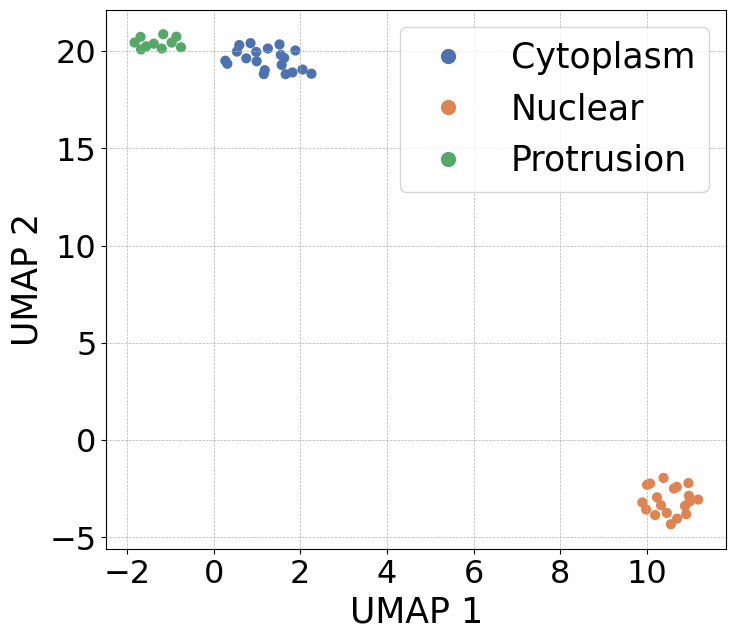

In [16]:
### plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.figure(figsize=(8, 7))
gene_labels = []
for i in gene_interested:
    if i in cytoplasm20List:
        gene_labels.append(0)
    elif i in nuclear20List:
        gene_labels.append(1)
    elif i in protrusion20List:
        gene_labels.append(2)
my_colors = ['#4C72B0', '#DD8452', '#55A868']

my_cmap = ListedColormap(my_colors)
plt.scatter(embeddings_np_subset_umap_SVC_49[:, 1], embeddings_np_subset_umap_SVC_49[:, 0], s=40,c=gene_labels, cmap=my_cmap)
### legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='Cytoplasm', markerfacecolor=my_cmap(0), markersize=12),
                    plt.Line2D([0], [0], marker='o', color='w', label='Nuclear', markerfacecolor=my_cmap(1), markersize=12),
                    plt.Line2D([0], [0], marker='o', color='w', label='Protrusion', markerfacecolor=my_cmap(2), markersize=12)],
           fontsize=25, loc='best')

plt.xlabel('UMAP 1', fontsize=25)
plt.xticks(fontsize=23)
plt.ylabel('UMAP 2', fontsize=25)
plt.yticks(fontsize=23)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [14]:
embeddings_cytoplasm_mean = (embeddings_np_subset_mean_SVC_49[:len(cytoplasm20List), :]).mean(axis=0)
embeddings_nuclear_mean = (embeddings_np_subset_mean_SVC_49[len(cytoplasm20List):len(nuclear20List)+len(cytoplasm20List), :]).mean(axis=0)
embeddings_protrusion_mean = (embeddings_np_subset_mean_SVC_49[len(nuclear20List)+len(cytoplasm20List):, :]).mean(axis=0)
def cosine_distance(x, y, eps=1e-12):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    sim = np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y) + eps)
    return 1.0 - sim
dist_nuclear_cytoplasm = cosine_distance(embeddings_nuclear_mean, embeddings_cytoplasm_mean)
dist_nuclear_protrusion = cosine_distance(embeddings_nuclear_mean, embeddings_protrusion_mean)
dist_cytoplasm_protrusion = cosine_distance(embeddings_cytoplasm_mean, embeddings_protrusion_mean)
print("dist_nuclear_cytoplasm:", dist_nuclear_cytoplasm)
print("dist_nuclear_protrusion:", dist_nuclear_protrusion)
print("dist_cytoplasm_protrusion:", dist_cytoplasm_protrusion)

dist_nuclear_cytoplasm: 0.1305655955137517
dist_nuclear_protrusion: 0.20249216131705017
dist_cytoplasm_protrusion: 0.057066147410912316


In [ ]:
gene_interested = [gene for gene in nuclearSub1List + nuclearSub2List + nuclearSub3List]
embeddings_np_subset_SVC_11 = embeddings_np[:, [np.where(gene_names == gene)[0][0] for gene in gene_interested], :]
print("shape of the data: ", embeddings_np_subset_SVC_11.shape)
embeddings_np_subset_mean_SVC_11 = embeddings_np_subset_SVC_11.mean(axis=0)  # Average over cells
print("shape of the data: ", embeddings_np_subset_mean_SVC_11.shape)

### umap
import umap
reducer = umap.UMAP()
reducer.set_params(random_state=0)
embeddings_np_subset_umap_SVC_11 = reducer.fit_transform(embeddings_np_subset_mean_SVC_11)
print("shape of the data: ", embeddings_np_subset_umap_SVC_49.shape)

shape of the data:  (157, 11, 384)
shape of the data:  (11, 384)
shape of the data:  (49, 2)


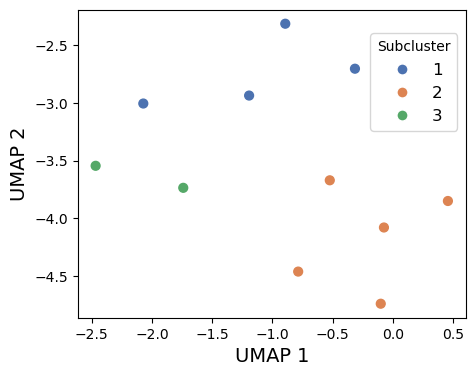

In [19]:

plt.figure(figsize=(5, 4))
gene_labels = []
for i in gene_interested:
    if i in nuclearSub1List:
        gene_labels.append(0)
    elif i in nuclearSub2List:
        gene_labels.append(1)
    elif i in nuclearSub3List:
        gene_labels.append(2)
my_colors = ['#4C72B0', '#DD8452', '#55A868']

my_cmap = ListedColormap(my_colors)
plt.scatter(embeddings_np_subset_umap_SVC_11[:, 0], embeddings_np_subset_umap_SVC_11[:, 1], s=40,c=gene_labels, cmap=my_cmap)
### legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor=my_cmap(0), markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor=my_cmap(1), markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', label='3', markerfacecolor=my_cmap(2), markersize=8)],
           fontsize=12, bbox_to_anchor=(1, 0.95),title='Subcluster')


plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
# plt.yticks([-14,-13.5,-13,-12.5,-12])
# plt.grid(True)
plt.show()

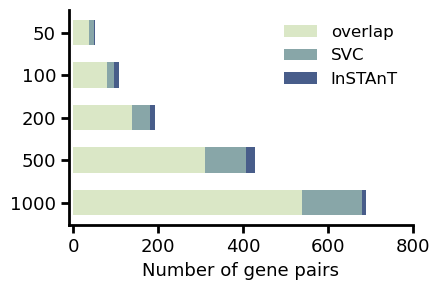

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
c1 = '#DAE7C6' 
c2 = '#88A6A8' 
c3 = '#485D8A' 
fig, ax = plt.subplots(figsize=(4.5, 3))

y = np.arange(5)

data1 = common_pairs_num[::-1]
data2 = [len(varified_pairs_SVC_50),len(varified_pairs_SVC_100),len(varified_pairs_SVC_200),len(varified_pairs_SVC_500), len(varified_pairs_SVC_1000)]
data3 = [len(varified_pairs_instant_50),len(varified_pairs_instant_100),len(varified_pairs_instant_200),len(varified_pairs_instant_500), len(varified_pairs_instant_1000)]
data2 = np.array(data2)
data3 = np.array(data3)
plt.barh(
    y, data1,
    color=c1, height=0.6,
    edgecolor=None, linewidth=1.5,
    label='overlap'
)

plt.barh(
    y, data2,
    left=data1,
    color=c2, height=0.6,
    edgecolor=None, linewidth=1.5,
    label='SVC'
)

plt.barh(
    y, data3,
    left=data1 + data2,
    color=c3, height=0.6,
    edgecolor=None, linewidth=1.5,
    label='InSTAnT'
)

ax.invert_yaxis()

plt.yticks([0,1,2,3,4])
ax.set_yticklabels(['50','100','200','500','1000'], rotation=0, fontsize=13)

plt.xticks([0,200,400,600,800], fontsize=13)
ax.set_xticklabels([0,200,400,600,800], rotation=0, fontsize=13)
ax.tick_params(axis='both', which='major', width=2, length=6)   
ax.tick_params(axis='both', which='minor', width=1.5, length=4) 
plt.xlabel('Number of gene pairs', fontsize=13)
plt.xlim(-10, 800)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.legend(fontsize=12, frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
instant_result['rank'] = np.arange(1, len(instant_result) + 1)

rank_dict = {}

for _, row in instant_result.iterrows():
    g1, g2 = row['gene_id1'], row['gene_id2']
    key = tuple(sorted((g1, g2)))  
    rank_dict[key] = row['rank']
    
frac_cells_dict = {}

for _, row in instant_result.iterrows():
    g1, g2 = row['gene_id1'], row['gene_id2']
    key = tuple(sorted((g1, g2))) 
    rank_dict[key] = row['frac_cells']

top_1000_frac_cells_instant = []

for gene1, gene2 in tqdm(gene_pairs_1000_SVC):
    key = tuple(sorted((gene1, gene2)))
    frac_cells = rank_dict.get(key, None) 
    top_1000_frac_cells_instant.append(frac_cells)
print("top_1000_frac_cells_instant:",top_1000_frac_cells_instant[:100])

100%|██████████| 1000/1000 [00:00<00:00, 792574.45it/s]

top_1000_frac_cells_instant: [0.9044585987261147, 0.8129032258064516, 0.8064516129032258, 0.6815286624203821, 0.7452229299363057, 0.66, 0.6645161290322581, 0.5266666666666666, 0.7579617834394905, 0.6040268456375839, 0.6794871794871795, 0.6533333333333333, 0.5526315789473685, 0.6644295302013423, 0.6025641025641025, 0.625, 0.5933333333333334, 0.3246753246753247, 0.3557046979865772, 0.4932432432432433, 0.467948717948718, 0.4533333333333333, 0.4370860927152318, 0.5290322580645161, 0.5197368421052632, 0.6624203821656051, 0.6233766233766234, 0.4333333333333333, 0.5733333333333334, 0.5064102564102564, 0.4701986754966888, 0.472972972972973, 0.25, 0.5286624203821656, 0.5032258064516129, 0.2611940298507462, 0.4370860927152318, 0.5723684210526315, 0.3733333333333334, 0.532051282051282, 0.3245033112582781, 0.448051948051948, 0.5526315789473685, 0.5131578947368421, 0.4423076923076923, 0.4331210191082803, 0.4133333333333333, 0.2040816326530612, 0.5540540540540541, 0.4189189189189189, 0.3896103896103